In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

# DC Motor simulation
## Parameters
### Motor
[Maxon DCX 22 EB KL 12V](https://www.maxongroup.com/medias/sys_master/root/8881021878302/EN-21-101.pdf)
11/20 W, 29.8 mNm, 7160 rpm

In [2]:
Maxon_RotorInertia = 9.0 # gcm2
Maxon_SpeedConstant = 416 # rpm/V
Maxon_TorqueConstant = 22.9 # mNm/A
Maxon_TerminalResistance = 1.84 # Ohms
Maxon_TerminalInductance = 0.198 # mH

Maxon_NominalCurrent = 1.3 # A
Maxon_NominalTorque = 29.5 # mMm
Maxon_StallCurrent = 6.54 # A

Maxon_MechanicalTimeConstant = 3.14e-3 # s

Added Toroidal Inductance to limit dc motor iron losses

In [3]:
Seabot_AddedInductance = 1.619e-3 # H
Seabot_AddedInductanceResistance = 480e-3 # Ohms

Parameters of the DC model
https://ctms.engin.umich.edu/CTMS/index.php?example=MotorSpeed&section=SystemModeling

https://aleksandarhaber.com/modeling-a-dc-motor-and-matlab-simulation/

In [4]:
J = Maxon_RotorInertia * 1e-7 # Moment of inertia (kg.m^2)
Ke = 1./(Maxon_SpeedConstant*2.*np.pi/60.) # Electromotive force constant  (V/rad/sec)
Kt = Maxon_TorqueConstant*1e-3 # Motor torque constant (N.m/Amp)
R = Maxon_TerminalResistance + Seabot_AddedInductanceResistance # Electric resistance (Ohm)
L = Maxon_TerminalInductance*1e-3 + Seabot_AddedInductance # Electric inductance (H)

### Reductor
[GPX22UP 103:1](https://www.maxongroup.com/medias/sys_master/root/8882582683678/EN-21-352.pdf)
3 stages

In [5]:
Maxon_Reduction = 103 # 103:1
Maxon_MaxContinuousTorque = 4.3 # Nm
Maxon_MassInertia = 0.6 # gcm2

### Endless Screw System

In [6]:
Screw_Thread = 1e-3 # m
Screw_Radius = 6e-3 # m
Screw_FrictionCoefficient = 0.2 # To be correctly evaluated ! Copper-Copper = 1.2
Piston_diam = 45e-3 # m

quadrature_resolution = 2048 * 4

### Environement

In [7]:
rho = 1025 # kg/m3
g = 9.81 # m/s-3
z_max = 100 # m

In [8]:
sensor_current_sensitivity = 264e-3 #66e-3 # V/A
dspic_adc_resolution = 1<<12 # resolution
dspic_adc_vcc = 3.3 # V
current_to_adc = sensor_current_sensitivity*dspic_adc_resolution/dspic_adc_vcc

## First validation
* Compute the torque at requiered at 100m

In [9]:
pistonSurface = np.pi*(Piston_diam/2.)**2
force100 = pistonSurface*rho*g*z_max
print('Force at 100 m = {:.2f} N'.format(force100))

i_screw=Screw_Thread/(2*Screw_Radius) # Note : error in the thesis formula : diam and not radius
force_to_torque_coeff = Screw_Radius*np.tan(Screw_FrictionCoefficient+i_screw)
torque100 = force_to_torque_coeff*force100
print('Torque at 100 m = {:.2f} Nm'.format(torque100))

weight100 = force100/g
print('Equivalent in kg for test at 100m : {:.2f} kg'.format(weight100))

Force at 100 m = 1599.22 N
Torque at 100 m = 2.79 Nm
Equivalent in kg for test at 100m : 163.02 kg


* Maximum torque at the output of the moto-reductor

In [10]:
max_torque_maxon = Maxon_NominalTorque*1.e-3*Maxon_Reduction
print('Nominal Torque (output reductor) = {:.2f} Nm'.format(max_torque_maxon))

torque_at_z = pistonSurface*rho*g* force_to_torque_coeff / Maxon_Reduction
print('Torque at 100 (output motor) = {:.2f} Nm'.format(torque_at_z*100))

Nominal Torque (output reductor) = 3.04 Nm
Torque at 100 (output motor) = 0.03 Nm


## Simulation
$J\ddot\theta=K_t i - z\cdot\text{torque_at_z}$

(note : we do not take into account the "No load current")

$L\dot{i}+Ri=V-K_e\dot\theta$

$\frac{d}{dt}\begin{bmatrix}
\theta \\
\dot\theta \\
i
\end{bmatrix}=
\begin{bmatrix}
0 & 1 & 0 \\
0 & 0 & \frac{K_t}{J}\\
0 & \frac{-K_e}{L} & \frac{-R}{L}\\
\end{bmatrix}
\begin{bmatrix}
\theta \\
\dot\theta \\
i
\end{bmatrix}+\begin{bmatrix}
0 & 0\\
0 & \frac{-\text{torque_at_z}}{J}\\
\frac{1}{L} & 0\\
\end{bmatrix}
\begin{bmatrix}
V \\
z \\
\end{bmatrix}$

In [11]:
A = np.array([[0., 1., 0.],[0., 0., Kt/J], [0., -Ke/L,-R/L]])
B = np.array([[0.0, 0.0],[0., -torque_at_z/J], [1./L, 0.]])
print('A = ', A)
print('B = ', B)

A =  [[ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.54444444e+04]
 [ 0.00000000e+00 -1.26334837e+01 -1.27682994e+03]]
B =  [[   0.            0.        ]
 [   0.         -301.38462397]
 [ 550.35773253    0.        ]]


State space : $x = \begin{bmatrix}\theta \\ \dot\theta \\ i\end{bmatrix}$
Input : $u = \begin{bmatrix}V\\ z\end{bmatrix}$ 

In [17]:
x = np.array([0., 0., 0.0])
u = np.array([12, 100.]) # V, m

dt = 1e-5
tmax = 0.1
result_x = np.array((0, x[0], x[1], x[2]))

def f(x, u):
    u_non_rev = u
    #if((Kt*x[2]-torque_at_z*u[1])<0):
    #    u_non_rev[1] = -Kt*x[2]/torque_at_z
    return (A @ x) + (B @ u_non_rev)

for t in np.arange(dt, tmax, dt):
    x+=f(x, u)*dt
    
    result_x = np.vstack([result_x, np.array((t, x[0], x[1], x[2]))])
    
result_i = np.transpose(result_x)[3] + 20e-3 # Add No load current

i_max = 4.283 A
i_end = 1.204 A
dtheta = 403.049 rad/s


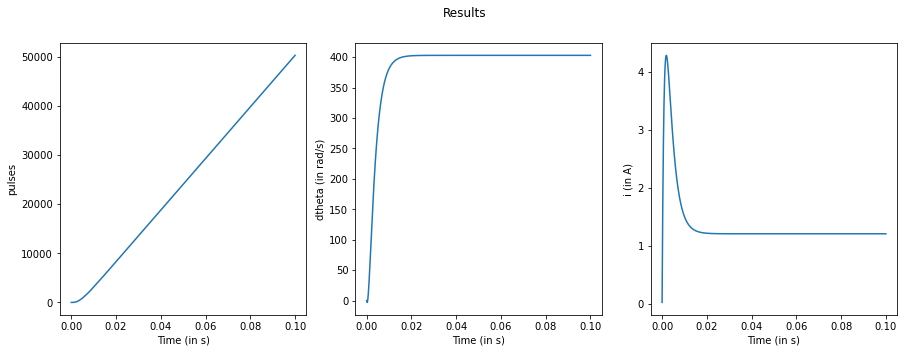

In [18]:
# Display
fig, axs = plt.subplots(1,3)
fig.suptitle('Results')
axs[0].plot(np.transpose(result_x)[0], np.floor(np.transpose(result_x)[1]*quadrature_resolution/(2*np.pi)))
axs[0].set_xlabel('Time (in s)')
#axs[0].set_ylabel('theta (in rad)')
axs[0].set_ylabel('pulses')

axs[1].plot(np.transpose(result_x)[0], np.transpose(result_x)[2])
axs[1].set_xlabel('Time (in s)')
axs[1].set_ylabel('dtheta (in rad/s)')

axs[2].plot(np.transpose(result_x)[0], result_i)
axs[2].set_xlabel('Time (in s)')
axs[2].set_ylabel('i (in A)')

# Analysis
print('i_max = {:.3f} A'.format(np.max(result_i)))
print('i_end = {:.3f} A'.format(result_i[-3]))
print('dtheta = {:.3f} rad/s'.format(np.max(np.transpose(result_x)[2])))

i_max = 60 bit
i_end = 6 bit


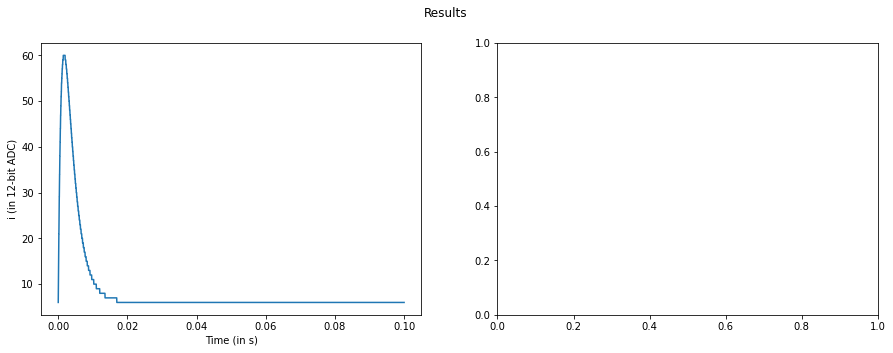

In [14]:
result_i_adc = np.floor(result_i*current_to_adc)

fig, axs = plt.subplots(1,2)
fig.suptitle('Results')
axs[0].plot(np.transpose(result_x)[0], result_i_adc)
axs[0].set_xlabel('Time (in s)')
axs[0].set_ylabel('i (in 12-bit ADC)')

print('i_max = {:g} bit'.format(np.max(result_i_adc)))
print('i_end = {:g} bit'.format(result_i_adc[-3]))